In [1]:
#module dependencies
import networkx as nx
import numpy as np
import sys
import itertools   
import time
from IPython.core.debugger import set_trace
import pandas as pd
import matplotlib.pyplot as plt 

In [2]:
def printGraph(G):
    nx.draw(G, with_labels=True, font_weight='bold')
    
def Diff(li1, li2): 
	return (list(set(li1) - set(li2))) 

def Union(lst1, lst2): 
    final_list = list(set(lst1 + lst2)) 
    return final_list 

def gray_vertices(G,C):
    dominating = []
    for u in C:
        dominating = Union(dominating,list(G[u]))
    return Diff(dominating,C)

def h(G,C):
    h = 0
    dominating = gray_vertices(G,C)
    dominating = np.union1d(dominating,np.asarray(C))
    for u in list(G.nodes):
        if u not in dominating:
            h = h+1
    return h

def p(G,C):
    H = G.subgraph(C)
    p = nx.number_connected_components(H)
    return p

def g(G,C):
    p_ = p(G,C)
    h_ = h(G,C)
    return p_+h_

def min_g(G,C):
    val = sys.maxsize
    x = None
    for u in list(G.nodes):
        val_ = g(G,C+[u])
        if(val_<val):
            val = val_
            x=u
    return x

def greedy_gk(G):
    C=[]
    while (True):
        exist = False
        for x in G.nodes:
            if g(G,C+[x])<g(G,C):
                exist = True
        if not exist:
            return C
        x = min_g(G,C)
        C = Union(C,[x])

def guha_khuller(G):
    C = greedy_gk(G)
    while p(G,C)>1:
        gray = gray_vertices(G,C)
        components = nx.connected_components(G.subgraph(C))
        a= list(next(components))[0]
        b = list(next(components))[0]
        path = nx.shortest_path(G,source=a,target=b)
        counter = 0
        for x in path:
            if x in gray:
                C = Union(C,[x])
                counter +=1
                if counter == 2:
                    break
    return C

def q(G,C):
    G2 = nx.Graph()
    G2.add_nodes_from(G.nodes)
    G2.add_edges_from(G.edges(C))
    return nx.number_connected_components(G2)

def chen_liestman(G):
    C = []
    V = list(G.nodes)
    while q(G,C)>=2:
        val = sys.maxsize
        v = None
        for u in Diff(V,C):
            res = q(G,Union(C,[u])) 
            if(res < val):
                val = res
                v = u
        C = Union(C,[v])
    return C

def marginal(G,f,A,X):
    return f(G,Union(A,X)) - f(G,A)

def wolsey_greedy(G,f):
    A =[]
    V = list(G.nodes)
    while f(G,A) < f(G,V):
        u = None
        val = 0-sys.maxsize #max negative val
        # considering c(x) to be constant for all vertices
        for x in Diff(V,A):
            res = marginal(G,f,A,[x])
            if res > val:
                    val = res 
                    u = x
        A = Union(A,[u])
    return A

def f(G,A):
    return len(G) - q(G,A)

def findsubsets(s, n): 
    return list(itertools.islice(itertools.combinations(s, n), 10))

def H(X,f,G,A):
    return -1*(marginal(G,f,A,X)/len(X))

#brute force approach
def chooses_subset(G,f,A,k):
    max_val = 0-sys.maxsize
    max_X = None
    V = list(G.nodes)
    for i in range(1,2*k):
        subsets = findsubsets(V,i)
        for subset in subsets:
            subset = list(subset)
            val = H(subset,f,G,A)
            if val > max_val:
                max_X = subset
                max_val = val
    return max_X

#Helper Function
def calculate(G,f,A,k,V):
    max_val = 0-sys.maxsize
    max_X = []
    subsets = findsubsets(V,k)
    for i in range(len(subsets)):
        subset = list(subsets[i])
        val = H(subset,f,G,A)
        if val > max_val:
            max_X = subset
            max_val = val
    return [max_val,max_X]

#random selection approach
def chooses_subset2(G,f,A,k,V):
    max_val = 0-sys.maxsize
    max_X = []
    min_index = 1
    max_index = 2*k-1
    while(min_index<max_index):
        index = int((min_index + max_index)/2)
        index1 = int((min_index + index)/2)
        index2 = int((max_index + index)/2)
        
        [val1,X1] = calculate(G,f,A,index1,V)
        [val2,X2] = calculate(G,f,A,index2,V)
        [val,X] = calculate(G,f,A,index,V)
        
        maxx = max(val1,max(val2,val))
        if maxx == val:
            max_X = X
            max_val = val 
            break
        elif maxx == val1:
            max_X = X1
            max_val = val
            min_index = min_index
            max_index = index
        else:
            max_X = X2
            max_val = val
            min_index = index
            max_index = max_index
    return max_X

def dgpwwz(G,f,k):
    C=[]
#     set_trace()
    while f(G,C)>2:
        V = Diff(G.nodes,C)
        X = chooses_subset2(G,f,C,k,V)
        if len(X) == 0:
            break
        C = Union(C,X)
    return C

def f2(G,A):
    return p(G,A)+q(G,A)

In [3]:
def get_random_graph(n,p):
    return nx.generators.random_graphs.connected_watts_strogatz_graph(n,5,p)

In [ ]:
#snippet to run different algorithms on random graphs
result = []
n = 200
while n<=1000:
    density = 0.1
    while density<=0.5:
        G = get_random_graph(n,density)
        start = time.time()
        res = dgpwwz(G,f2,5)
        end = time.time()
        size1 = len(res)
        time1 = end-start

        start = time.time()
        res = wolsey_greedy(G,f)
        end = time.time()
        size2 = len(res)
        time2 = end-start

        start = time.time()
        res = chen_liestman(G)
        end = time.time()
        size3 = len(res)
        time3 = end-start

        start = time.time()
        res = guha_khuller(G)
        end = time.time()
        size4 = len(res)
        time4 = end-start

        result.append([
                n,
                density,
                size1,
                time1,
                size2,
                time2,
                size3,
                time3,
                size4,
                time4,
            ]
        )
        print("Done for n ="+str(n)+" and density ="+str(density))
        density+=0.1
        break
    n+=50

In [127]:
import pandas as pd
df = pd.DataFrame(result, columns=[
                "no_of_vertices",
                "density",
                "cds_size_dgpwwz",
                'time_dgpwwz',
                "cds_size_wolsey_greedy",
                "time_wolsey_greedy",
                "cds_size_chen_liestman",
                "time_chen_liestman",
                "cds_size_guha_khuller",
                "time_guha_khuller",])
df.to_csv("output_15.csv")

In [46]:
#helper function
def run_on_graph(G):
    start = time.time()
    res = dgpwwz(G,f2,5)
    end = time.time()
    size1 = len(res)
    time1 = end-start

    start = time.time()
    res = wolsey_greedy(G,f)
    end = time.time()
    size2 = len(res)
    time2 = end-start

    start = time.time()
    res = chen_liestman(G)
    end = time.time()
    size3 = len(res)
    time3 = end-start

    start = time.time()
    res = guha_khuller(G)
    end = time.time()
    size4 = len(res)
    time4 = end-start

    return [
            len(G.nodes()),
            size1,
            time1,
            size2,
            time2,
            size3,
            time3,
            size4,
            time4,
        ]

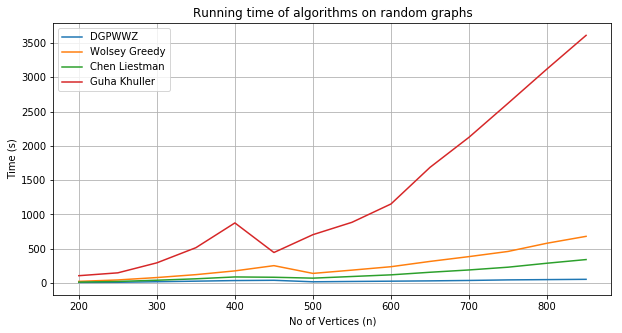

In [180]:
fig = plt.figure(figsize=(10,5))
plt.plot(df["no_of_vertices"],df["time_dgpwwz"], label = 'DGPWWZ')
plt.plot(df["no_of_vertices"],df["time_wolsey_greedy"], label = 'Wolsey Greedy')
plt.plot(df["no_of_vertices"],df["time_chen_liestman"], label = 'Chen Liestman')
plt.plot(df["no_of_vertices"],df["time_guha_khuller"], label = 'Guha Khuller')
plt.xlabel('No of Vertices (n)')
plt.ylabel('Time (s)')
plt.title('Running time of algorithms on random graphs')
plt.grid(True)
plt.legend(loc='best')
plt.savefig('random_time.png')

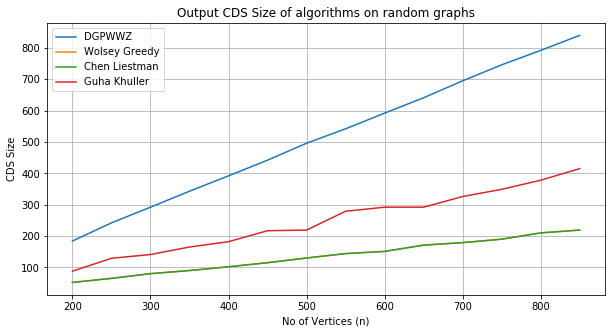

In [181]:
fig = plt.figure(figsize=(10,5))
plt.plot(df["no_of_vertices"],df["cds_size_dgpwwz"], label = 'DGPWWZ')
plt.plot(df["no_of_vertices"],df["cds_size_wolsey_greedy"], label = 'Wolsey Greedy')
plt.plot(df["no_of_vertices"],df["cds_size_chen_liestman"], label = 'Chen Liestman')
plt.plot(df["no_of_vertices"],df["cds_size_guha_khuller"], label = 'Guha Khuller')
plt.xlabel('No of Vertices (n)')
plt.ylabel('CDS Size')
plt.title('Output CDS Size of algorithms on random graphs')
plt.grid(True)
plt.legend(loc='best')
plt.savefig('random_size.png')

In [131]:
df2 = pd.read_csv("complete_graph.csv")
df2

,no_of_vertices,density,cds_size,time(sec),cds_size.1,time(sec).1,cds_size.2,time(sec).2,cds_size.3,time(sec).3
0,10,0.1,3,0.065824,2,0.003989,2,0.001995,3,0.019947
1,10,0.2,3,0.061834,3,0.005980,3,0.002997,3,0.020944
2,10,0.3,4,0.079786,2,0.003989,2,0.001995,3,0.019947
3,10,0.4,4,0.055850,2,0.005128,2,0.001854,2,0.015701
4,10,0.5,2,0.040522,2,0.004716,2,0.001995,2,0.013963
5,15,0.1,9,0.074844,4,0.014960,4,0.006981,7,0.058801
6,15,0.2,7,0.054852,3,0.010970,3,0.005983,4,0.049866
7,15,0.3,8,0.052856,4,0.013978,4,0.005969,5,0.058022
8,15,0.4,9,0.104682,4,0.018993,4,0.006007,5,0.074733
9,15,0.5,5,0.076840,4,0.016974,4,0.009080,5,0.060704


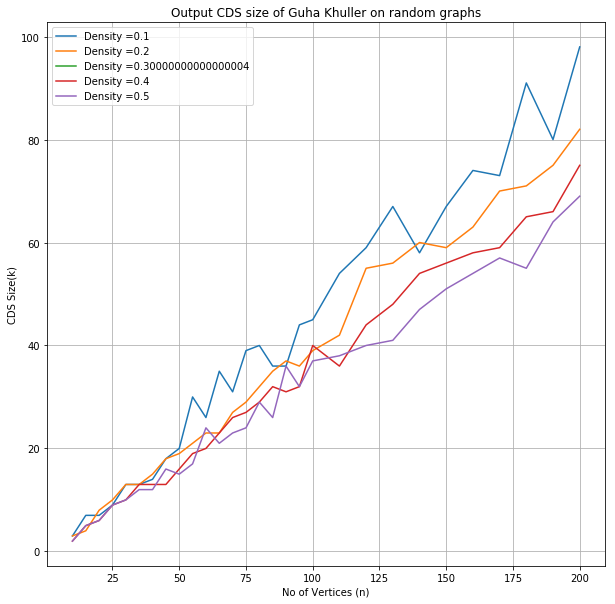

In [179]:
fig = plt.figure(figsize=(10,10))
d = 0.1
while d<=0.5:
    df3 = df2[df2["density"] == d]
    plt.plot(df3["no_of_vertices"],df3["cds_size.3"], label = 'Density ='+str(d))
#     plt.plot(df3["no_of_vertices"],df3["cds_size.1"], label = 'Wolsey Greedy')
#     plt.plot(df3["no_of_vertices"],df3["cds_size.2"], label = 'Chen Liestman')
#     plt.plot(df3["no_of_vertices"],df3["cds_size.3"], label = 'Guha Khuller')
    d+=0.1
plt.xlabel('No of Vertices (n)')
plt.ylabel('CDS Size(k)')
plt.title('Output CDS size of Guha Khuller on random graphs')
plt.grid(True)
plt.savefig('guha_khuller_size.png')
plt.legend(loc='best')

C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


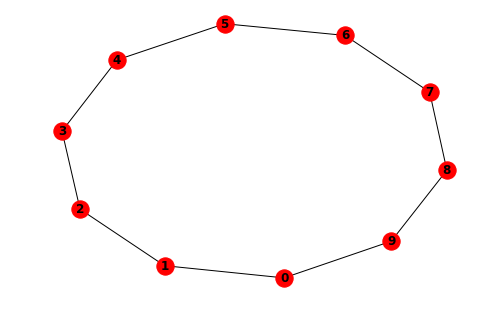

In [183]:
G = nx.generators.classic.cycle_graph(10)
printGraph(G)

[0, 3, 6, 7]


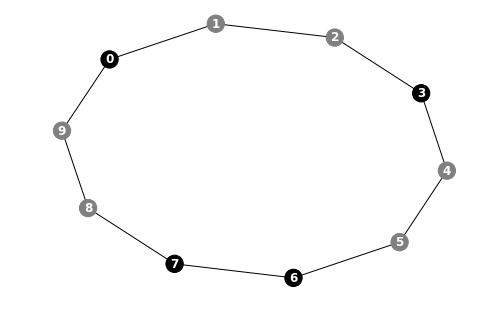

In [202]:
print(greedy_gk(G))
values = ['black',
          'grey',
          'grey',
          'black',
          'grey',
          'grey',
          'black',
          'black',
          'grey',
          'grey',
         ]
nx.draw(G,cmap=plt.get_cmap('viridis'),node_color=values, with_labels=True, font_weight='bold', font_color = 'white')

In [ ]:
n = 1
r = []
while(n<=8):
    G = nx.generators.classic.balanced_tree(2,n)
    res = run_on_graph(G)
    r.append(res)
    n +=1
    print("Complete for n="+str(n))

In [241]:
df = pd.DataFrame(r, columns=[
                "no_of_vertices",
                "cds_size",
                'time',
                "cds_size",
                "time",
                "cds_size",
                "time",
                "cds_size",
                "time",])
df.to_csv("output/bbt.csv")
df = pd.DataFrame(r, columns=[
                "no_of_vertices",
                "cds_size",
                'time1',
                "cds_size",
                "time2",
                "cds_size",
                "time3",
                "cds_size",
                "time4",])

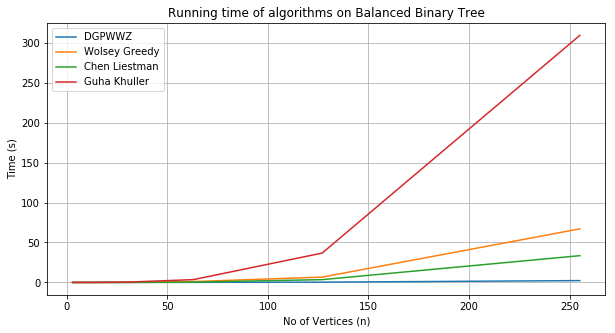

In [242]:
fig = plt.figure(figsize=(10,5))
plt.plot(df["no_of_vertices"],df["time1"], label = 'DGPWWZ')
plt.plot(df["no_of_vertices"],df["time2"], label = 'Wolsey Greedy')
plt.plot(df["no_of_vertices"],df["time3"], label = 'Chen Liestman')
plt.plot(df["no_of_vertices"],df["time4"], label = 'Guha Khuller')
plt.xlabel('No of Vertices (n)')
plt.ylabel('Time (s)')
plt.title('Running time of algorithms on Balanced Binary Tree')
plt.grid(True)
plt.legend(loc='best')
plt.savefig('output/bbt_time.png')

In [55]:
def printCds(G,C):
    values = []
    for v in list(G.nodes):
        if v in C:
            values.append('black')
        else:
            values.append('grey')
    nx.draw(G,cmap=plt.get_cmap('viridis'),node_color=values, with_labels=True, font_weight='bold', font_color = 'white')

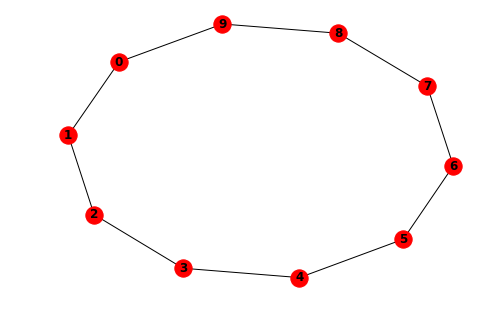

In [56]:
G = nx.nx.generators.classic.cycle_graph(10)
printGraph(G)

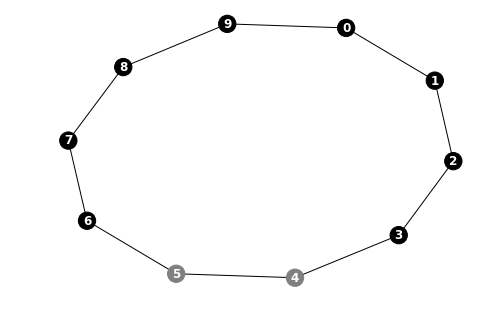

In [57]:
C = guha_khuller(G)
printCds(G,C)

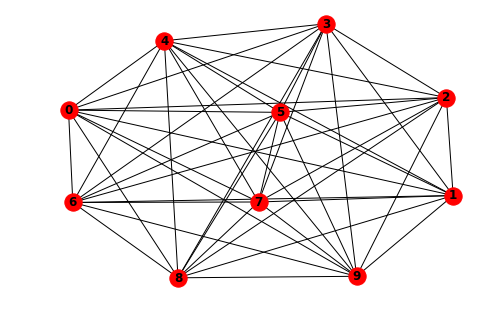

In [58]:
G = nx.nx.generators.classic.complete_graph(10)
printGraph(G)

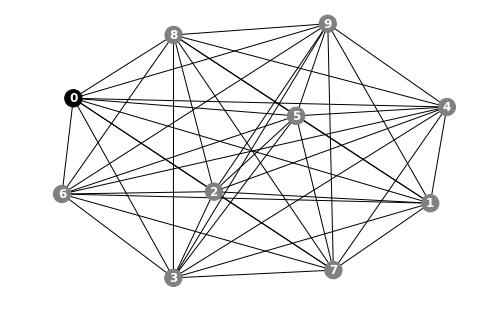

In [59]:
C = guha_khuller(G)
printCds(G,C)

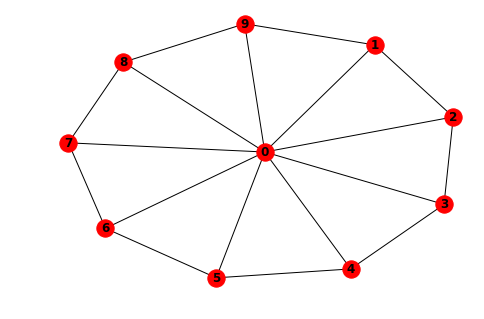

In [61]:
G = nx.nx.generators.classic.wheel_graph(10)
printGraph(G)

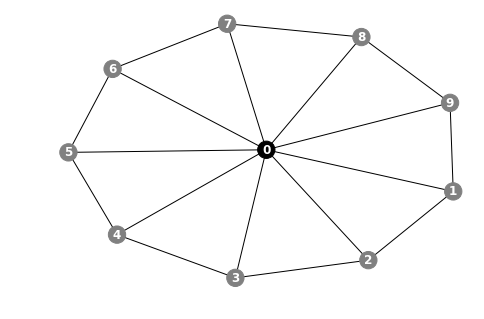

In [62]:
C = guha_khuller(G)
printCds(G,C)

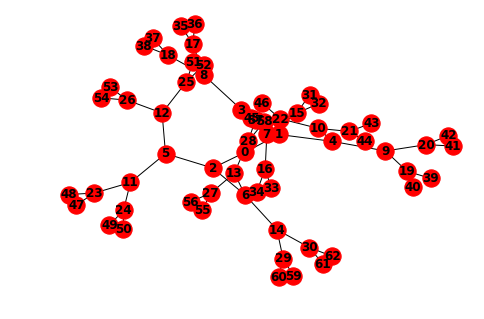

In [65]:
G = nx.nx.generators.classic.balanced_tree(2,5)
printGraph(G)

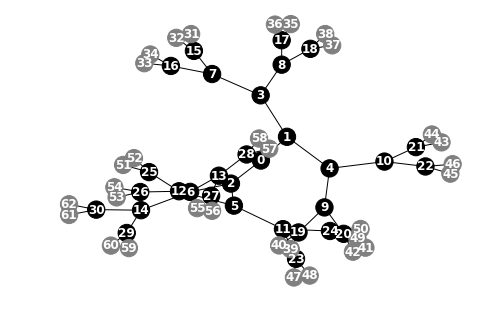

In [66]:
C = guha_khuller(G)
printCds(G,C)